<h1>DengAI data at first glance<h1>

The DengAI data set is part of the competition on DrivenData website.
The goal is to predict the number of in infected (total_cases label) for each city and weekofyear in the test set. There are two cities, San Juan and Iquitos, with test data spanning 5 and 3 years respectively. Throughout, missing values have been filled as NaNs.

In the training set, there are several groups of well defined features:

- NOAA's GHCN daily climate data weather station measurements
- PERSIANN satellite precipitation measurements
- Satelite vegetation Normalized Diference Vegetation Index (NDVI)

This is a time series dataset, and all features are reported weekly. Since Dengue fever is an infective disease spread by mosquitos, it is not unreasonable to assume that weekly number of cases depends on numbers of cases from previous weeks and climate parameters even further in the past.  


In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline 

import missingno as msno 
from scipy.interpolate import interp1d



In [2]:
cases_weekly = pd.read_csv(r'/home/milica/Desktop/competition 2/data/dengue_labels_train.csv')
features = pd.read_csv(r'/home/milica/Desktop/competition 2/data/dengue_features_train.csv')

print('feature columns:', features.columns)
print('cases_weekly columns:', cases_weekly.columns)

feature columns: Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')
cases_weekly columns: Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')


First, let's move data around a bit. 

Here we have data for two cities. San Juan, Puerto Rico and Iquitos, Peru. Let's devide it into separate dataframes, since those need to be analyzed separately. 

Also, on the time axes we have weeks of the year, which is not so informative. Let's index data by date.

In [3]:
features.drop(['year', 'weekofyear', 'city'], axis=1, inplace=True)
cases_weekly.drop(['year', 'weekofyear'], axis=1, inplace=True)

In [4]:
print('Shape of casses weekly df:', cases_weekly.shape, 'Shape of df features:',features.shape)
data = pd.concat([cases_weekly, features], axis=1) 

sj = data.loc[data['city'] == 'sj']
iq = data.loc[data['city'] == 'iq']

print('Shape of San Juan:', sj.shape, 'Shape of Inquitos:', iq.shape)

Shape of casses weekly df: (1456, 2) Shape of df features: (1456, 21)
Shape of San Juan: (936, 23) Shape of Inquitos: (520, 23)


Let's see how number of cases behave throughout the years for both cities.

In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.total_cases, mode='lines', name='San Juan'))
fig.add_trace(go.Scatter(x=iq.week_start_date, y=iq.total_cases, mode='lines', name='Iquitos'))
fig.update_layout(title='Deng fever records', xaxis_title='Week of the year', yaxis_title = 'Number of casec')

Clear seasonality can be noticed, though there is no trend. Also, there is way fewer records for Iquitos than San Juan. There is reason to compare the cities among themselves for now. 
This dataset has nicely engineered and clearly grouped features. Let's see how does the number of cases follow other variables separately, by the city.

But first, let's deal with missing values.

<AxesSubplot:>

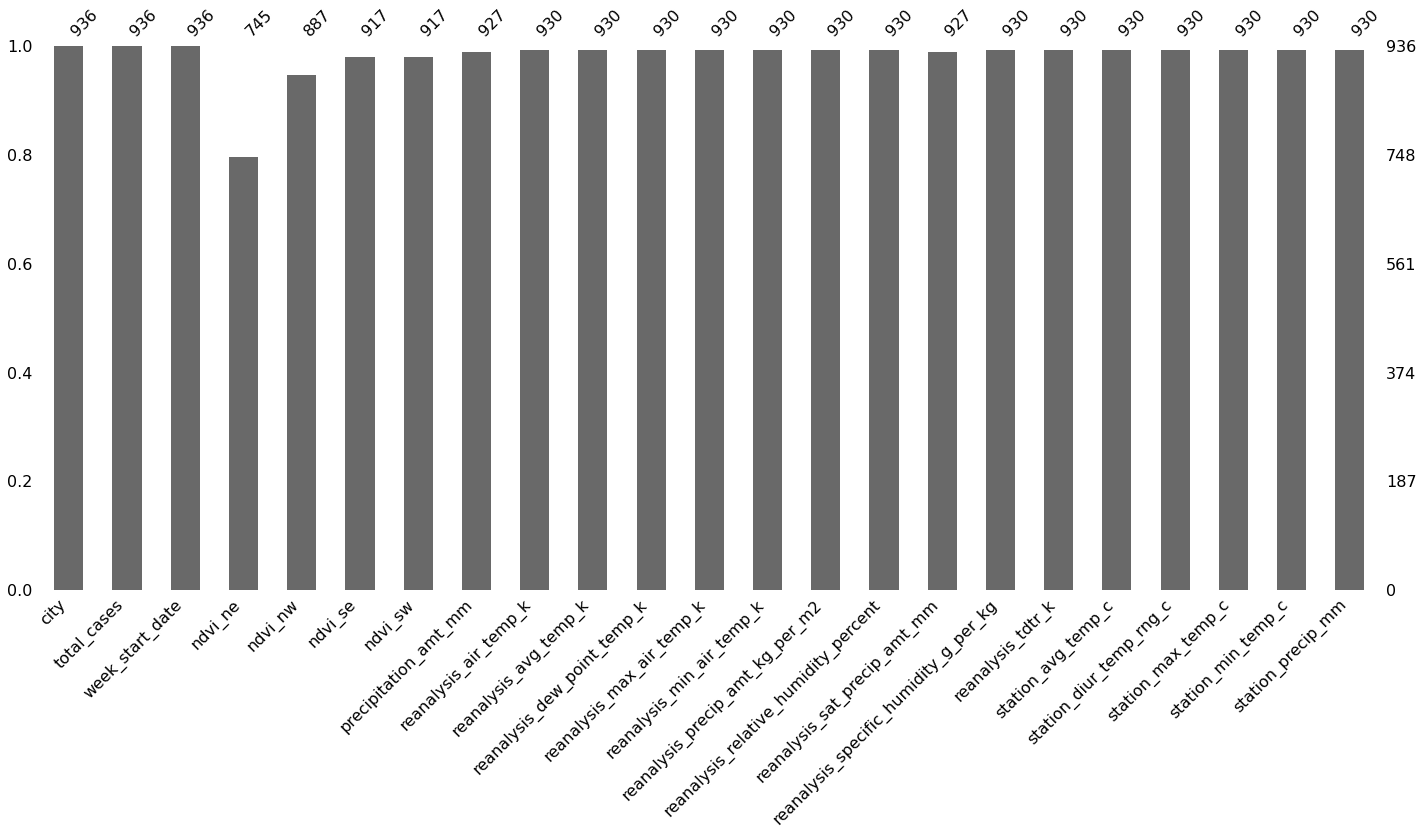

In [6]:
msno.bar(sj)

The most missing values have the variable ndvi_ne – (Normal Difference Vegetation Index) Pixel northeast of city centroid, folowed by the rest of the NDVI variables. The majority of variables have 6 values missing troughout the data frame. What is important to investigate also is the distribution of the missing values and whether they are clustered and/or variable dependent. 


<AxesSubplot:>

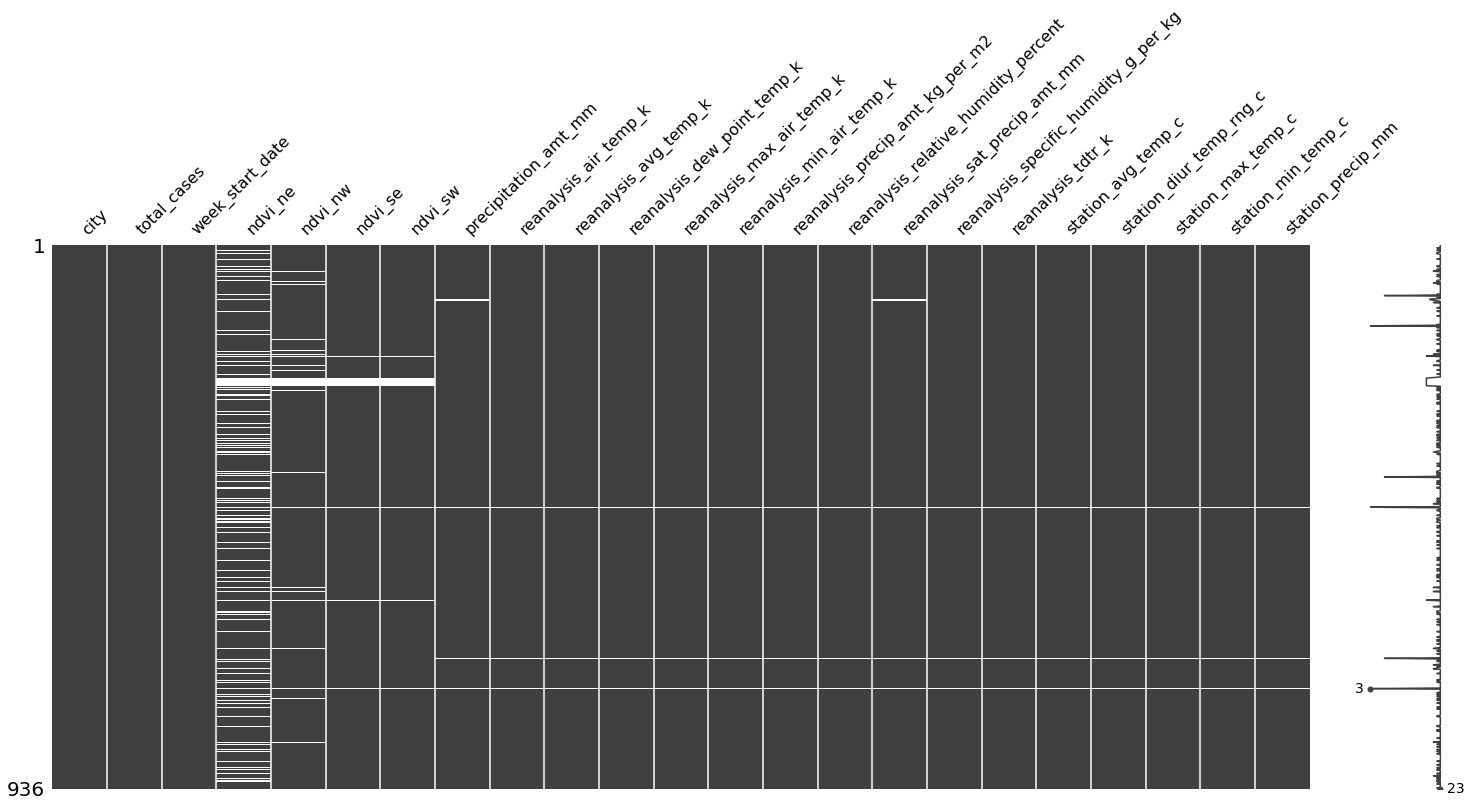

In [7]:
msno.matrix(sj) 

It's easily noticable that there are several weeks with vast majority of climate variables absent. For time series data especially is unwise to impute a constant (the mean or zero), as it is the popular choice with rectangular data. Since all those variables are time dependant, the imputation of the missing values can be a lot more precise and therefore it can introduce way less bias. 

The matrix of missing values also shows us that ndvi_ne has more or less uniform distribution of missing values. There is a cluster of missing values troughout satelite vegetation features (NDVI variables) that needs more careful approach. 

In [8]:
# print(sj.columns)
fig = px.imshow(sj.corr(), title='Correlation between features')
fig.show()

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_ne, mode='lines', name='ndvi_ne'))
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_nw, mode='lines', name='ndvi_nw'))
fig.update_layout(title='Normalized difference vegetation index NE and NW of the city', xaxis_title='Week of the year', yaxis_title = 'NDVI')

The variables ndvi_ne and ndvi_nw are heavily correlated, which is to be expected. ndvi_ne seems to have more variability, therefore the use of higher order spline might be justified for imputation of missing variables. 

As per usual, any imputation method is more or less a guesswork, which introduces bias in the data. 

Both time series have obvious trend and seasonal component. The one of the right ways to impute missing data in this case would be to decompose series, remove trend and seasonality, impute the data and then throw the trend and season back in. The other is to model the data as SARIMA (Seasonal AutoRegressive Integrated Moving Average) and calculate missing data from the modeldirectly. We will go back to this procedure if NDVI varables prove to be important for the final predictive model (data snooping danger). For now, higher order spline interpolation method will do.

In [10]:
sj_drop_na = sj.ndvi_ne.dropna()
impute_cubic = interp1d(sj_drop_na.index, sj_drop_na, kind='cubic')

fig = go.Figure()
fig.add_trace(go.Scatter(x=sj.week_start_date, y=impute_cubic(sj.ndvi_ne.index), mode='lines', name='ndvi_ne imputed', line=dict(color='MediumPurple', width=2)))
fig.add_trace(go.Scatter(x=sj.week_start_date, y=sj.ndvi_ne, mode='lines', name='ndvi_ne'))
fig.update_layout(autosize=False, width=1700, title='The imputed vs. original NDVI NE', xaxis_title='Week of the year', yaxis_title = 'NDVI')

The same imputation method is applied for the whole sj and iq data. 

In [11]:
columns_to_impute = [e for e in sj.columns if e not in ('city', 'week_start_date')]

for city in [sj, iq]:
    for column in columns_to_impute:
        temp = city[column].dropna()
        impute_cubic = interp1d(temp.index, temp, kind='cubic')
        city[column] = impute_cubic(city[column].index)

sj.to_csv(sj_imputed.csv)
ig.to_csv(iq_imputed.csv)


The next steps would be the to check how features compare to each other and to number of cases label. As mentioned in the intro Dengue fever is an infective disease, therefore it might be worth while to go through correlations between variables at different lags. 